<a href="https://colab.research.google.com/github/Gus-1003/TADS_Projeto_PalmaS/blob/main/ExperimentoCirculosBrancos/script_1_Professor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste com comandos simples:

*   Fonte: https://github.com/Gus-1003/PalmeS_Professor/blob/main/src/script_1.ipynb



## Importando Bibliotecas e Ferramentas:

In [47]:
from google.colab import drive

import cv2 
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow

## Conectando ao Driver

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Recebendo Imagem:

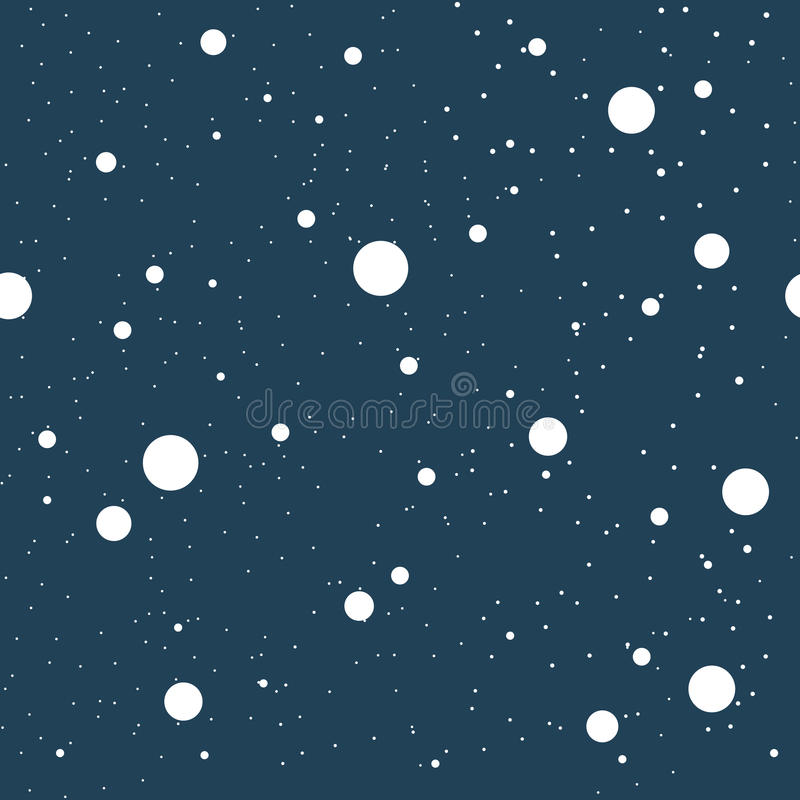

In [11]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/fig_control_1.jpg")
cv2_imshow(im)

## Analise das Dimensões da imagem:

In [14]:
print('Dim:' + str(im.shape))

Dim:(800, 800, 3)


## Convertendo para tons de Cinza:

In [16]:
#desaturation - convert bgr to gray for limiarization
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

## Limiarização da Imagem:

152.0


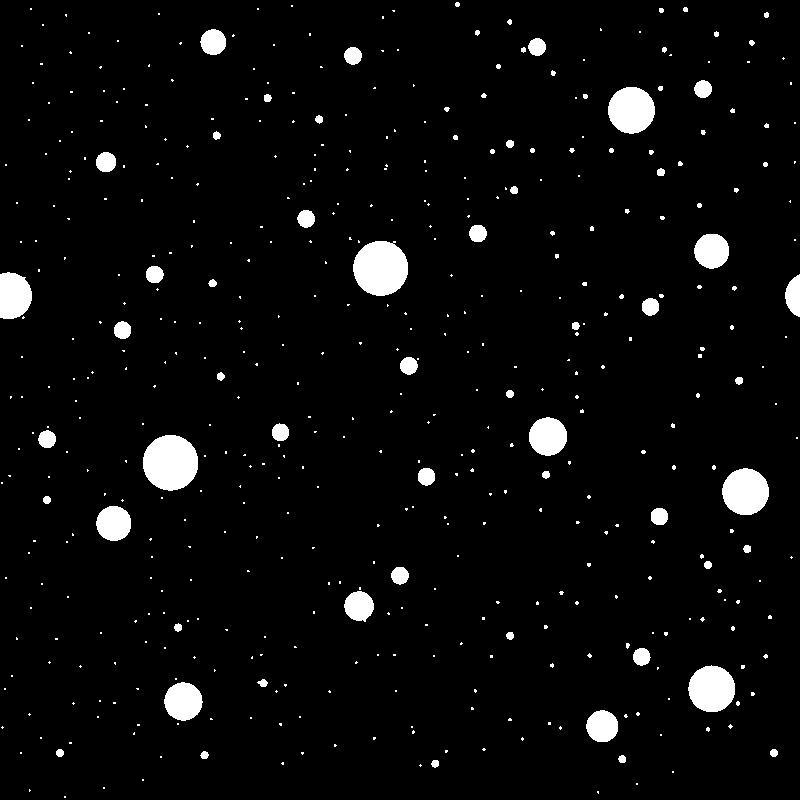

In [19]:
#auto otsu
#can be applied to uni e bimodal histograms
# segmentation based on shape, pixels (color), histogram
# binary segmentation - binarization, thresholding

ret,th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret)
cv2_imshow(th)

## Cálculo da área de Interesse:

In [20]:
# soma total de pixels brancos:

n_pixels_white = 0
for i in range(th.shape[0]):
    for j in range(th.shape[1]):
        if th[i,j] == 255:
            n_pixels_white += 1
            
total_area = th.shape[0]*th.shape[1]
interest_area = n_pixels_white/total_area
print('Interest area: ' + str(interest_area*100) + ' %')

Interest area: 4.12375 %


## Aplicação de contornos nos objetos convexos detectados:

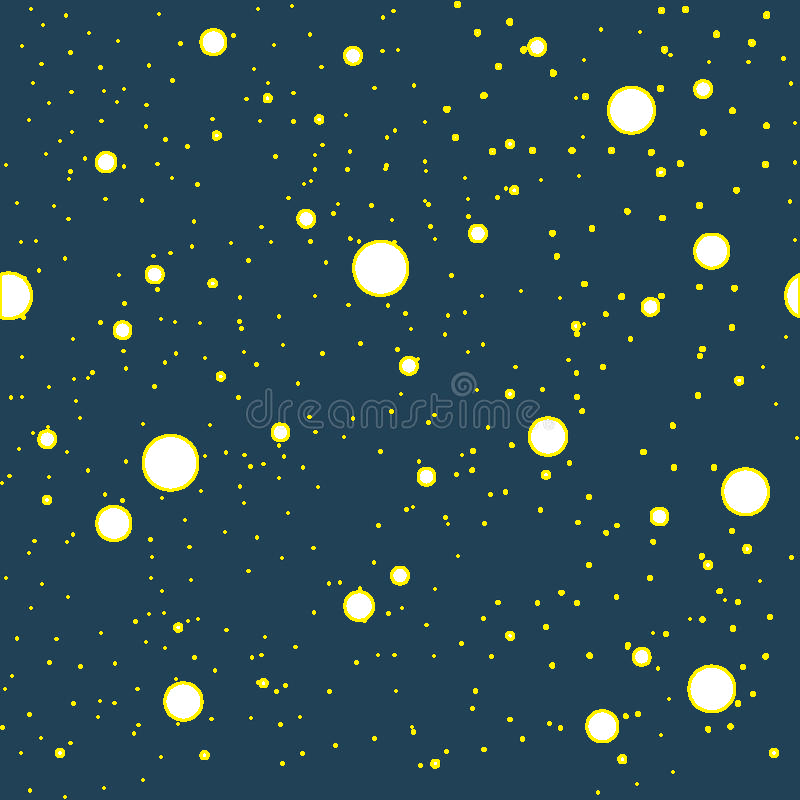

In [51]:
#here the objects areas are convex (closed)

contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(im, contours, -1,(0,242,255), 2)
cv2_imshow(im)

In [52]:
print (str(len(contours))) # Contagem da quantidade de objetos identificados
print(type(contours)) # Tipagem da estrutura "contours"

487
<class 'list'>


## Desenvolvimento de Features a partir dos objetos identificados anteriormente:

In [25]:
areas = []
perimeters = []
centroids_x = []
centroids_y = []

for c in contours:
    M = cv2.moments(c)
    areas.append(M['m00'])
    perimeters.append(cv2.arcLength(c,True)) #if not convex, False
    if M['m00'] != 0:
        centroids_x.append(M['m10']/M['m00'])
        centroids_y.append(M['m01']/M['m00'])
    else:
        centroids_x.append(0)
        centroids_y.append(0)
        
print(len(areas))
print(len(perimeters))
#print(areas) outliers

487
487


# Criação de um Dicionario a partir das Features geradas:

In [48]:
features = [areas, perimeters]

interest_area_contours = sum(areas)/total_area
print(interest_area_contours)

d = {'area': areas, 'perimiter': perimeters}
#d = {'centroid_x': centroids_x, 'centroid_y': centroids_y, 'area': areas, 'perimiter': perimeters}
df = pd.DataFrame(data=d)

0.03624765625


In [50]:
print(df.describe())

              area   perimiter
count   487.000000  487.000000
mean     47.635524   12.594081
std     230.155539   23.205022
min       1.000000    4.000000
25%       1.000000    4.000000
50%       2.000000    6.000000
75%       7.000000   10.242641
max    2349.500000  188.509666


## Aplicação do Método de Aprendizagem Kmeans:

In [29]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df) # Metodo fit

KMeans(n_clusters=4)

### Classificação dos Objetos:

In [ ]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    class_ = kmeans.predict([df.iloc[cont]])[0]
    conts[class_].append(cnt)

In [36]:
im2 = cv2.drawContours(im, conts[0], -1, (0, 0, 0), thickness=2)
im2 = cv2.drawContours(im2, conts[1], -1, (20, 150, 232), thickness=2)
im2 = cv2.drawContours(im2, conts[2], -1, (82, 184, 10), thickness=2)
im2 = cv2.drawContours(im2, conts[3], -1, (0, 262, 255), thickness=2)
           
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

class 0: 457 individuals
class 1: 5 individuals
class 2: 7 individuals
class 3: 18 individuals


### Demonstração dos Resultados:


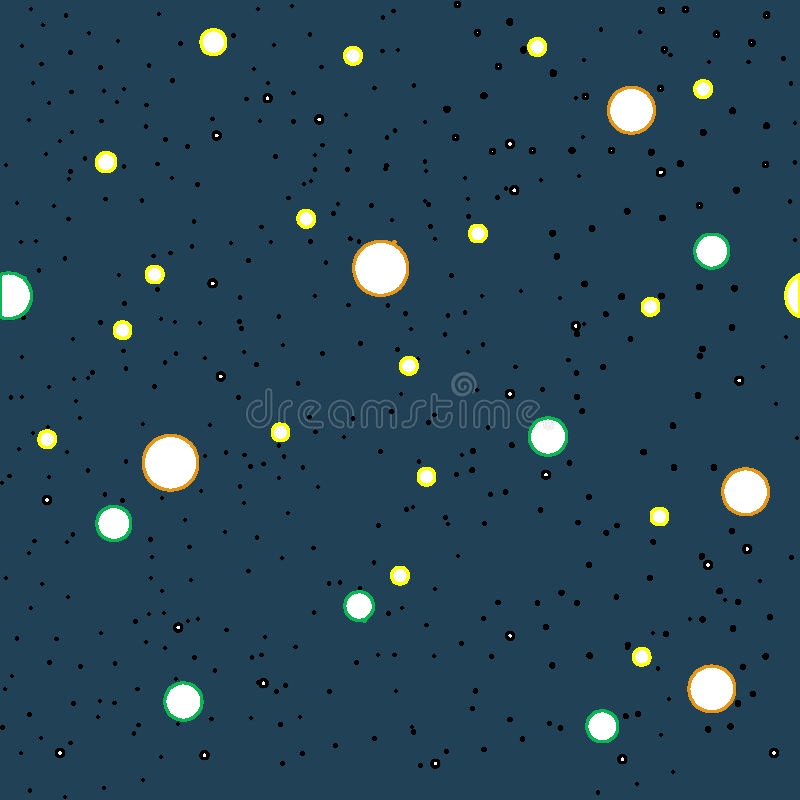

In [37]:
cv2_imshow(im2)

## Aplicação de Sistema Fuzzy - Comprovação dos Resultados


In [41]:
!pip install fuzzy-c-means
from fcmeans import FCM
fcm = FCM(n_clusters=4)
X = df.to_numpy()
fcm.fit(X)

     |████████████████████████████████| 11.1 MB 6.6 MB/s 


### Classificação dos Objetos:

In [43]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    
    r = df.iloc[cont].to_numpy()
    class_ = fcm.predict(r)
    #print(class_)
    conts[class_[0]].append(cnt)

In [44]:
    
im2 = cv2.drawContours(im, conts[0], -1, (0, 0, 0), thickness=2)
im2 = cv2.drawContours(im2, conts[1], -1, (20, 150, 232), thickness=2)
im2 = cv2.drawContours(im2, conts[2], -1, (82, 184, 10), thickness=2)
im2 = cv2.drawContours(im2, conts[3], -1, (0, 262, 255), thickness=2)
            
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

class 0: 18 individuals
class 1: 7 individuals
class 2: 5 individuals
class 3: 457 individuals


### Demonstração dos Resultados:


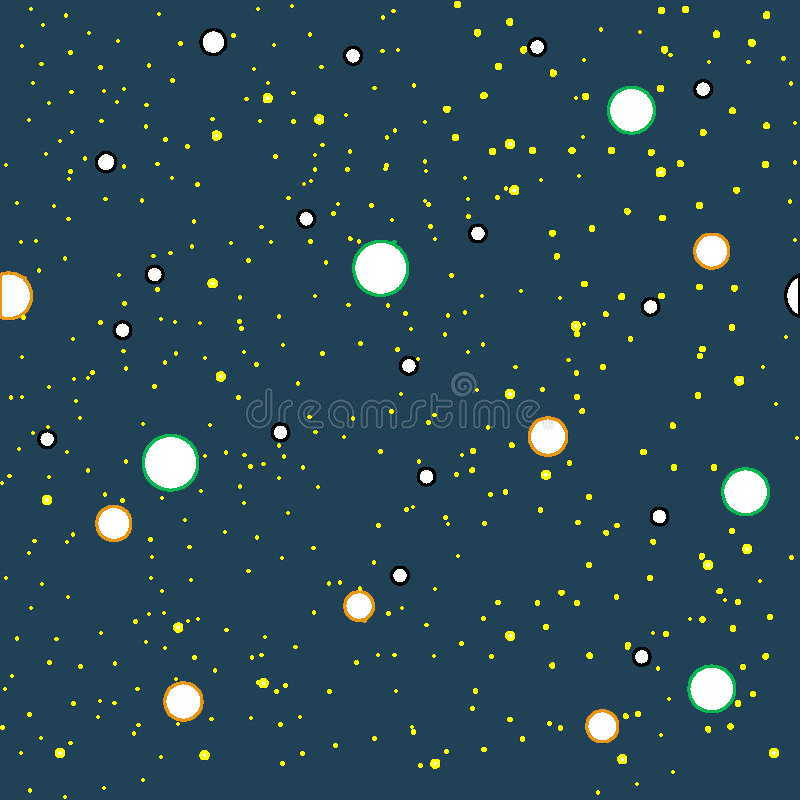

In [46]:
cv2_imshow(im2)